In [60]:
DATASET_PATH = '../data/raw/data_carrers.csv'
OUTPUT_PATH = '../data/processed/processed-dataset.csv'
import pandas as pd
import numpy as np
import torch
import random
import re
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from transformers import MarianMTModel, MarianTokenizer, pipeline
from transformers import pipeline as paraphrase_pipeline

# Import libraries
import torch
import warnings
warnings.filterwarnings("ignore")






# 1) Modelo para traducir de español a inglés
model_name_es_en = "Helsinki-NLP/opus-mt-es-en"
translator_es_en = pipeline(
    "translation_es_to_en",
    model=model_name_es_en,
    tokenizer=model_name_es_en
)

# 2) Modelo para traducir de inglés a español
model_name_en_es = "Helsinki-NLP/opus-mt-en-es"
translator_en_es = pipeline(
    "translation_en_to_es",
    model=model_name_en_es,
    tokenizer=model_name_en_es
)




from transformers import PegasusForConditionalGeneration, PegasusTokenizer

model_name = "tuner007/pegasus_paraphrase"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

def paraphrase_pegasus(input_text, num_return_sequences=3):
    batch = tokenizer(
        [input_text],
        truncation=True,
        padding="longest",
        return_tensors="pt"
    )
    outputs = model.generate(
        **batch,
        max_length=128,
        num_beams=5,
        num_return_sequences=num_return_sequences,
        temperature=1.5,
        top_k=50,
        top_p=0.9,
        repetition_penalty=2.5
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Prueba con un ejemplo
input_text = "Siempre me ha gustado entender cómo funcionan las cosas y mejorar procesos."
text = translator_es_en(input_text, max_length=512, truncation=True) 

paraphrased_texts = paraphrase_pegasus(text[0]['translation_text'])

print("Parafraseos generados:")
for idx, para in enumerate(paraphrased_texts):
    print(f"{idx + 1}. {para}")







def manual_back_translation(text, translator_es_en, translator_en_es):
    # 1) Traducir de español a inglés
    result_en = translator_es_en(text, max_length=512, truncation=True)
    # result_en es una lista de diccionarios [{'translation_text': "..."}]
    text_en = result_en[0]["translation_text"]

    # 2) Traducir la versión en inglés de vuelta a español
    result_es = translator_en_es(text_en, max_length=512, truncation=True)
    text_es = result_es[0]["translation_text"]

    return text_es



# import random
# from nltk.corpus import wordnet

# def synonym_replacement(text, replacement_probability=0.4):
#     """
#     Reemplaza palabras por sinónimos con una probabilidad determinada.
    
#     :param text: Texto de entrada.
#     :param replacement_probability: Probabilidad de reemplazar cada palabra (entre 0 y 1).
#     :return: Texto modificado con sinónimos.
#     """
#     words = text.split()
#     new_words = []
    
#     for word in words:
#         # Decidir si reemplazar la palabra actual
#         if random.random() < replacement_probability:
#             synonyms = wordnet.synsets(word)
#             if synonyms:
#                 # Elegir el primer sinónimo disponible
#                 synonym = synonyms[0].lemmas()[0].name()
#                 new_words.append(synonym)
#             else:
#                 # Si no hay sinónimos, conservar la palabra original
#                 new_words.append(word)
#         else:
#             # Conservar la palabra original si no se reemplaza
#             new_words.append(word)
    
#     return " ".join(new_words)
# # Ejemplo
# text = translator_es_en("Quiero contribuir al desarrollo de una infraestructura sostenible", max_length=512, truncation=True) 

# augmented_text = synonym_replacement( text[0]["translation_text"])
# print(augmented_text)
# 'I want to contribute to the development of sustainable infrastructure'
# 'I privation to contribute to the development of sustainable infrastructure'

# def paraphrase_text(text, carrer, num_return_sequences=3):
#     # Prompt mejorado
#     prompt = f"Parafrasea el siguiente texto relacionado con la carrera {carrer}: {text}"
    
#     try:
#         # Configuración del parafraseador con parámetros mejorados
#         results = paraphraser(
#             prompt,
#             max_length=128,
#             num_return_sequences=num_return_sequences,
#             num_beams=5,  # Explora más opciones para obtener parafraseos variados
#             temperature=1.5,  # Fomenta creatividad en los resultados
#             top_k=50,  # Considera las 50 palabras más probables
#             top_p=0.9,  # Fomenta diversidad con nucleus sampling
#             clean_up_tokenization_spaces=True
#         )

#         # Filtrar resultados para evitar duplicados o textos incoherentes
#         filtered_results = []
#         for para_text in results:
#             if para_text['generated_text'] not in filtered_results and len(para_text['generated_text'].split()) > 3:
#                 filtered_results.append(para_text['generated_text'])

#         # Manejo de caso: si no se generan resultados válidos
#         if not filtered_results:
#             return "No se pudo generar un parafraseo válido."

#         # Retorna todos los resultados parafraseados
#         return filtered_results

#     except Exception as e:
#         # Manejo de errores
#         print(f"Error al generar parafraseo: {e}")
#         return ["Error al generar el parafraseo."]

# Cargar el dataset
df = pd.read_csv(DATASET_PATH, encoding="UTF-8")

df_augmented_texts = []
df_augmented_labels = []
for idx, row in df.iterrows():
    original_text = row['TEXTO']
    label = row['CARRERA']

    # Genera, por ejemplo, 1 o 2 versiones back-translated
    # ¡Ojo! Esto puede ser lento si tu dataset es grande
    for _ in range(1):
        # Ejecutar la traducción ida y vuelta
        back_translated = manual_back_translation(
            original_text,
            translator_es_en,
            translator_en_es
        )
        df_augmented_texts.append(back_translated)
        df_augmented_labels.append(label)
    
    text = translator_es_en(original_text, max_length=512, truncation=True) 

    paraphrased_texts = paraphrase_pegasus(text[0]['translation_text'])

    
    for para_text in paraphrased_texts:
        df_augmented_texts.append(translator_en_es(para_text, max_length=512, truncation=True)[0]['translation_text'] )
        df_augmented_labels.append(label)
        

# Crear el df de ejemplos aumentados
df_aug = pd.DataFrame({
    'TEXTO': df_augmented_texts,
    'CARRERA': df_augmented_labels
})

# Concatenar con el original
df_final = pd.concat([df, df_aug]).reset_index(drop=True)

df = df_final


# Eliminar valores nulos y duplicados
df = df.dropna()
df = df.drop_duplicates()
# Preprocesar el texto
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\sáéíóúñü]', '', text)  # Elimina caracteres especiales pero mantiene caracteres acentuados
    text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
    text = text.strip()  # Elimina espacios en blanco al inicio y al final
    return text

df['TEXTO'] = df['TEXTO'].apply(preprocess_text)

# Mapear las categorías a índices numéricos
print(df['CARRERA'].unique())
categories = df['CARRERA'].unique().tolist()
category_to_index = {category: idx for idx, category in enumerate(categories)}
df['LABEL'] = df['CARRERA'].map(category_to_index)

texts = df['TEXTO'].tolist()
labels = df['LABEL'].tolist()

df.to_csv(OUTPUT_PATH, index=False)

num_registros = df.shape[0]
print(f"Número total de registros en el dataset final: {num_registros}")

print(labels)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parafraseos generados:
1. I like to understand how things work.
2. I like to understand how things work and improve processes.
3. I like to understand how things work and how they can be improved.
['INDUSTRIAL' 'CIVIL' 'INFORMÁTICA' 'TELECOMUNICACIONES' 'ARQUITECTURA'
 'FILOSOFÍA' 'PSICOLOGÍA' 'LETRAS' 'COMUNICACIÓN SOCIAL' 'EDUCACIÓN'
 'ADMINISTRACIÓN' 'CONTADURÍA' 'RELACIONES INDUSTRIALES' 'SOCIOLOGÍA'
 'ECONOMÍA' 'DERECHO' 'TEOLOGÍA']
Número total de registros en el dataset final: 4685
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 1

In [61]:


tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels)


In [62]:

# Convertir tensores a numpy arrays
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()
labels_np = labels.numpy()

# División en entrenamiento+validación y prueba
X_train_val, X_test, y_train_val, y_test, mask_train_val, mask_test = train_test_split(
    input_ids_np, labels_np, attention_mask_np, test_size=0.2, random_state=42, stratify=labels_np)

# División en entrenamiento y validación
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_val, y_train_val, mask_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(y_train, y_val.shape, y_test.shape)
# Convertir a tensores
train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.long), torch.tensor(mask_train,dtype=torch.long), torch.tensor(y_train,dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.long), torch.tensor(mask_val,dtype=torch.long), torch.tensor(y_val,dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(mask_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', 
                                    num_labels=len(category_to_index), 
                                    hidden_dropout_prob=0.3, 
                                    attention_probs_dropout_prob=0.3)

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', config=config)

optimizer = AdamW(model.parameters(), lr=1e-5,eps=1e-8, weight_decay=0.01)

# Suponiendo que 'y_train' contiene las etiquetas de entrenamiento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


[ 9  9  6 ... 16 13  5] (937,) (937,)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
## BUCLE DE ENTRENAMIENTO

epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
# Configurar el modelo en modo de entrenamiento

patience = 2
early_stopping_counter = 0
best_val_loss = float('inf')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Después de calcular class_weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = CrossEntropyLoss(weight=class_weights)
model.to(device)
model.train()

training_losses = []
validation_losses = []
validation_accuracies = []
training_accuracies = []
training_f1_scores = []
validation_f1_scores = []  # Agrega esta línea aquí
learning_rates = []


for epoch in range(epochs):
    ### Entrenamiento ###
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Entrenamiento"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
                # Almacenar predicciones y etiquetas
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())
        
    learning_rates.append(optimizer.param_groups[0]['lr'])

    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
    train_true_labels, train_predictions, average='weighted')
    training_accuracies.append(train_accuracy)
    training_f1_scores.append(f1)


    ### Validación ###
    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validación"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    validation_losses.append(avg_val_loss)

    # Calcular precisión en validación
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_accuracies.append(val_accuracy)
    
    # Después de calcular avg_val_loss y val_accuracy, agrega:
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_true_labels, val_predictions, average='weighted')
    validation_f1_scores.append(f1)
    


    print(f"Epoch {epoch+1}/{epochs}, Pérdida Entrenamiento: {avg_train_loss:.4f}, Pérdida Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.4f}")
    
    # Definir variables para Early Stopping
    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model_state.bin')  # Guarda el mejor modelo
    else:
        early_stopping_counter += 1
        print(f"No hay mejora en la pérdida de validación. Paciencia: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("Early Stopping activado")
        break

Epoch 1/20 - Validación: 100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


Epoch 1/20, Pérdida Entrenamiento: 2.8444, Pérdida Validación: 2.8259, Precisión Validación: 0.0672


Epoch 2/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch 2/20, Pérdida Entrenamiento: 2.8156, Pérdida Validación: 2.7213, Precisión Validación: 0.2551


Epoch 3/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Epoch 3/20, Pérdida Entrenamiento: 2.5085, Pérdida Validación: 1.7763, Precisión Validación: 0.7097


Epoch 4/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch 4/20, Pérdida Entrenamiento: 1.6118, Pérdida Validación: 0.8950, Precisión Validación: 0.8154


Epoch 5/20 - Validación: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch 5/20, Pérdida Entrenamiento: 0.9976, Pérdida Validación: 0.5645, Precisión Validación: 0.8549


Epoch 6/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


Epoch 6/20, Pérdida Entrenamiento: 0.7203, Pérdida Validación: 0.4351, Precisión Validación: 0.8709


Epoch 7/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Epoch 7/20, Pérdida Entrenamiento: 0.5524, Pérdida Validación: 0.3687, Precisión Validación: 0.8869


Epoch 8/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


Epoch 8/20, Pérdida Entrenamiento: 0.4451, Pérdida Validación: 0.3021, Precisión Validación: 0.9104


Epoch 9/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


Epoch 9/20, Pérdida Entrenamiento: 0.3726, Pérdida Validación: 0.2827, Precisión Validación: 0.9136


Epoch 10/20 - Validación: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


Epoch 10/20, Pérdida Entrenamiento: 0.3132, Pérdida Validación: 0.2566, Precisión Validación: 0.9242


Epoch 11/20 - Validación: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


Epoch 11/20, Pérdida Entrenamiento: 0.2950, Pérdida Validación: 0.2440, Precisión Validación: 0.9221


Epoch 12/20 - Validación: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch 12/20, Pérdida Entrenamiento: 0.2736, Pérdida Validación: 0.2356, Precisión Validación: 0.9274


Epoch 13/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


Epoch 13/20, Pérdida Entrenamiento: 0.2332, Pérdida Validación: 0.2213, Precisión Validación: 0.9328


Epoch 14/20 - Validación: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


Epoch 14/20, Pérdida Entrenamiento: 0.2369, Pérdida Validación: 0.2278, Precisión Validación: 0.9328
No hay mejora en la pérdida de validación. Paciencia: 1/2


Epoch 15/20 - Validación: 100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


Epoch 15/20, Pérdida Entrenamiento: 0.2224, Pérdida Validación: 0.2183, Precisión Validación: 0.9328


Epoch 16/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Epoch 16/20, Pérdida Entrenamiento: 0.2199, Pérdida Validación: 0.2148, Precisión Validación: 0.9306


Epoch 17/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


Epoch 17/20, Pérdida Entrenamiento: 0.2071, Pérdida Validación: 0.2102, Precisión Validación: 0.9328


Epoch 18/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


Epoch 18/20, Pérdida Entrenamiento: 0.1957, Pérdida Validación: 0.2122, Precisión Validación: 0.9328
No hay mejora en la pérdida de validación. Paciencia: 1/2


Epoch 19/20 - Validación: 100%|██████████| 30/30 [00:22<00:00,  1.36it/s]

Epoch 19/20, Pérdida Entrenamiento: 0.1966, Pérdida Validación: 0.2124, Precisión Validación: 0.9328
No hay mejora en la pérdida de validación. Paciencia: 2/2
Early Stopping activado


Evaluación en Conjunto de Prueba: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


                         precision    recall  f1-score   support

             INDUSTRIAL       0.87      0.84      0.86        64
                  CIVIL       0.90      0.91      0.91        58
            INFORMÁTICA       0.85      0.95      0.89        58
     TELECOMUNICACIONES       0.92      0.84      0.88        57
           ARQUITECTURA       0.93      0.91      0.92        57
              FILOSOFÍA       0.98      1.00      0.99        52
             PSICOLOGÍA       0.95      0.97      0.96        58
                 LETRAS       0.96      1.00      0.98        53
    COMUNICACIÓN SOCIAL       0.93      0.91      0.92        55
              EDUCACIÓN       0.91      0.96      0.94        53
         ADMINISTRACIÓN       0.81      0.91      0.85        55
             CONTADURÍA       0.94      0.92      0.93        52
RELACIONES INDUSTRIALES       0.93      0.86      0.90        50
             SOCIOLOGÍA       0.98      0.91      0.94        53
               ECONOMÍA 

<Figure size 1800x500 with 0 Axes>

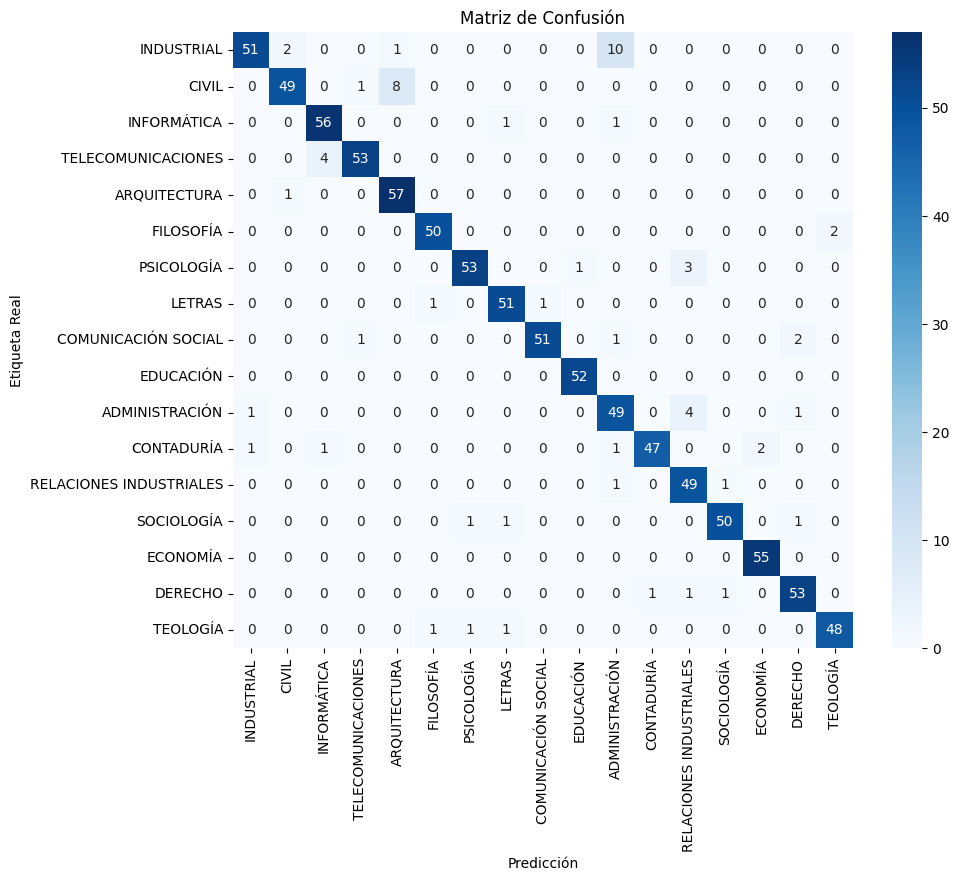

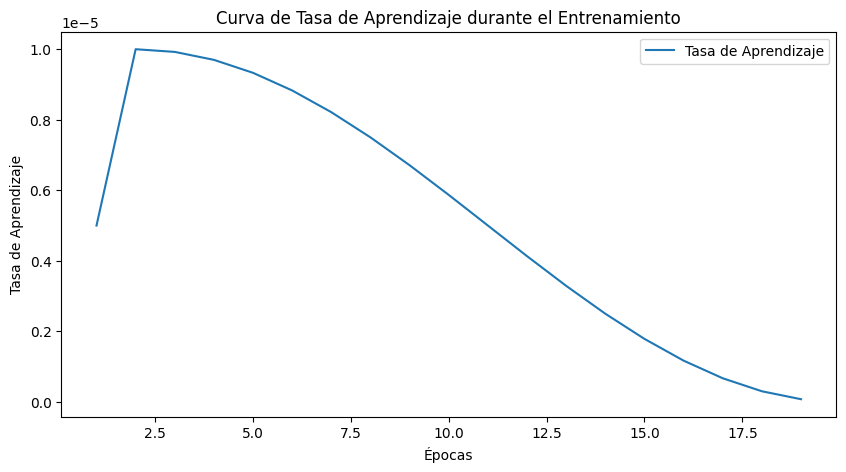

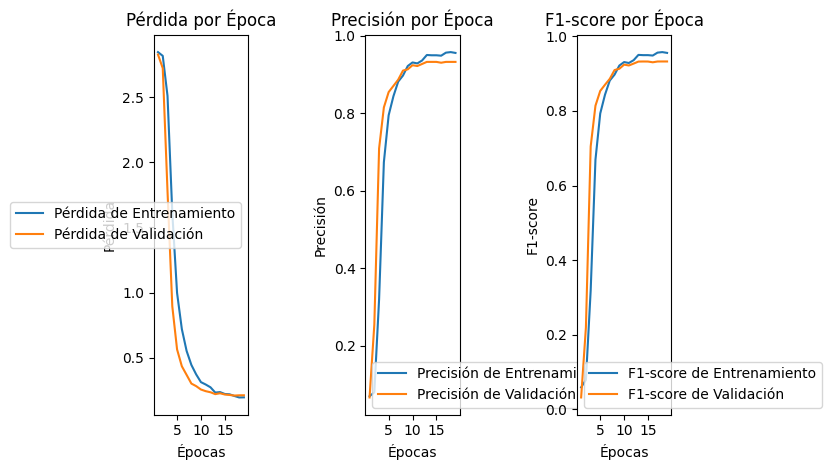

In [64]:
# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_state.bin', weights_only=True))

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluación en Conjunto de Prueba"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy()) 

# Generar el reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(test_true_labels, test_predictions, target_names=categories))

  
## MONITOREO DE GRÁFICOS Y METRICAS

epochs_range = range(1, len(training_losses) + 1)

plt.figure(figsize=(18, 5))

#generar matriz de confusion para la justificacion de la escogencia del algoritmo

######CODIGO A IMPLEMENTAR ######

import seaborn as sns

# Obtener la matriz de confusión en el conjunto de validación
conf_matrix = confusion_matrix(val_true_labels, val_predictions)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# generar la grafica de learning rate (curva de aprendizaje)


# Graficar la tasa de aprendizaje durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, label="Tasa de Aprendizaje")
plt.xlabel('Épocas')
plt.ylabel('Tasa de Aprendizaje')
plt.title('Curva de Tasa de Aprendizaje durante el Entrenamiento')
plt.legend()
plt.show()
####### CODIGO A IMPLEMENTAR ######

# Gráfica de pérdidas
plt.subplot(1, 3, 1)
plt.plot(epochs_range, training_losses, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, validation_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida por Época')

# Gráfica de precisión
plt.subplot(1, 3, 2)
plt.plot(epochs_range, training_accuracies, label='Precisión de Entrenamiento')
plt.plot(epochs_range, validation_accuracies, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión por Época')

# Gráfica de F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, training_f1_scores, label='F1-score de Entrenamiento')
plt.plot(epochs_range, validation_f1_scores, label='F1-score de Validación')
plt.xlabel('Épocas')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1-score por Época')

plt.tight_layout()
plt.show()


Para reforzar la justificación de la implementación, podrías generar más gráficas que incluyan:

Curva ROC y AUC:

La Curva ROC (Receiver Operating Characteristic) muestra el rendimiento del modelo en clasificación binaria, y el AUC (Area Under Curve) indica qué tan bien puede distinguir el modelo entre las clases. Esto es especialmente útil si estás trabajando con clasificación binaria (por ejemplo, clasificar respuestas como positivas o negativas).
Matriz de confusión:

La matriz de confusión te muestra cómo el modelo está clasificando las respuestas en cada clase. Esto puede proporcionar una comprensión más profunda de cómo el modelo está manejando cada categoría de respuesta en el contexto de orientación vocacional.
Learning Rate Curve:

Una gráfica del learning rate a lo largo del tiempo puede proporcionar información sobre cómo la tasa de aprendizaje está influyendo en el rendimiento del modelo.
¿Te gustaría que genere alguna de estas gráficas adicionales para complementar la justificación del modelo que has implementado?